In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = "C:\\Users\\Dharani\\Downloads\\P5 Image Captioning\\Flicker8k_Dataset"

In [3]:
data = pd.read_csv("C:\\Users\\Dharani\\Downloads\\image captions.csv")
data.head()

,image,Caption_no,Caption
0,1305564994_00513f9a5b.jpg,0,A man in street racer armor be examine the tir...
1,1305564994_00513f9a5b.jpg,1,Two racer drive a white bike down a road .
2,1305564994_00513f9a5b.jpg,2,Two motorist be ride along on their vehicle th...
3,1305564994_00513f9a5b.jpg,3,Two person be in a small race car drive by a g...
4,1305564994_00513f9a5b.jpg,4,Two person in race uniform in a street car .


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40460 entries, 0 to 40459
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       40460 non-null  object
 1   Caption_no  40460 non-null  int64 
 2   Caption     40460 non-null  object
dtypes: int64(1), object(2)
memory usage: 948.4+ KB


In [5]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:\\Users\\Dharani\\Downloads\\P5 Image Captioning\\Flicker8k_Dataset/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.Caption[i], 20)))
        plt.axis("off")

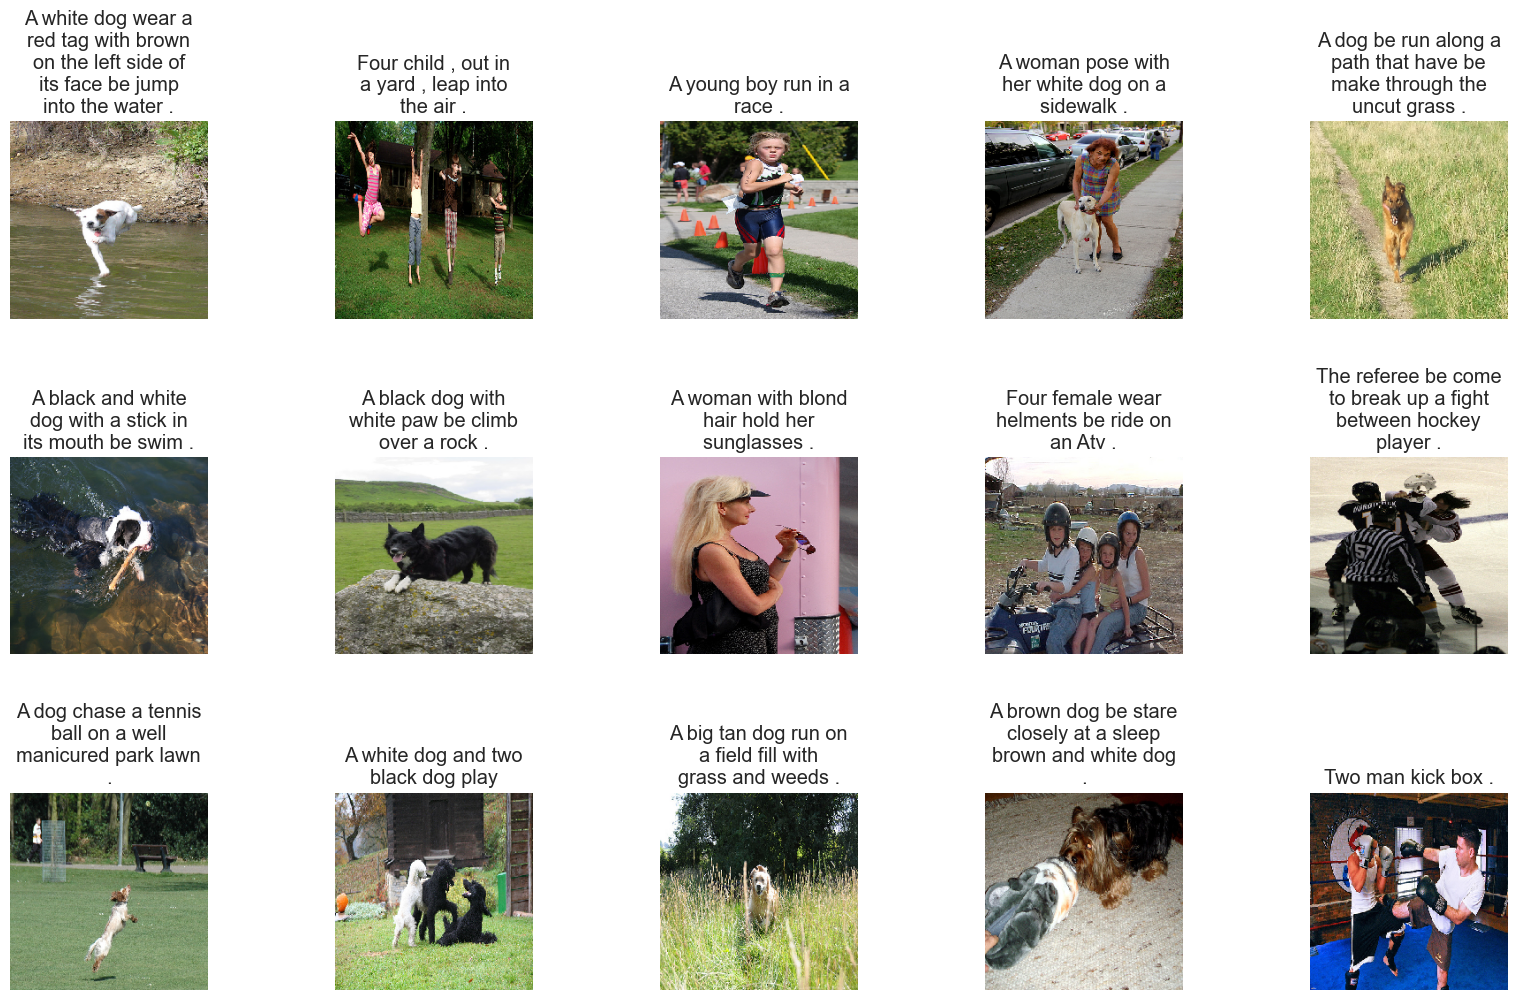

In [6]:
display_images(data.sample(15))

In [7]:
def text_preprocessing(data):
    data['Caption'] = data['Caption'].apply(lambda x: x.lower())
    data['Caption'] = data['Caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['Caption'] = data['Caption'].apply(lambda x: x.replace("\s+"," "))
    data['Caption'] = data['Caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['Caption'] = "startseq "+data['Caption']+" endseq"
    return data

In [8]:
data = text_preprocessing(data)
Captions = data['Caption'].tolist()
Captions[:10]

["startseq man in street racer armor be examine the tire of another racer 's motorbike endseq",
 'startseq two racer drive white bike down road endseq',
 'startseq two motorist be ride along on their vehicle that be oddly design and color endseq',
 'startseq two person be in small race car drive by green hill endseq',
 'startseq two person in race uniform in street car endseq',
 'startseq firefighter extinguish fire under the hood of car endseq',
 'startseq fireman spray water into the hood of small white car on jack endseq',
 'startseq fireman spray inside the open hood of small white car on jack endseq',
 'startseq fireman use firehose on car engine that be up on carjack endseq',
 'startseq firefighter use water to extinguish car that be on fire endseq']

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(Caption.split()) for Caption in Captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([Captions[1]])[0]

[1, 12, 539, 318, 17, 68, 41, 147, 2]

In [10]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img
    for image in tqdm(data['image'].unique().tolist()):
        img = load_img(os.path.join(image_path, image),target_size=(img_size,img_size))
        img = img_to_array(img)
        img = img/255.
        img = np.expand_dims(img,axis=0)
        feature = fe.predict(img, verbose=0)
        features[image] = feature

In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [12]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [13]:
from tensorflow.keras.utils import plot_model

In [14]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [15]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [16]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [17]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [18]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [19]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

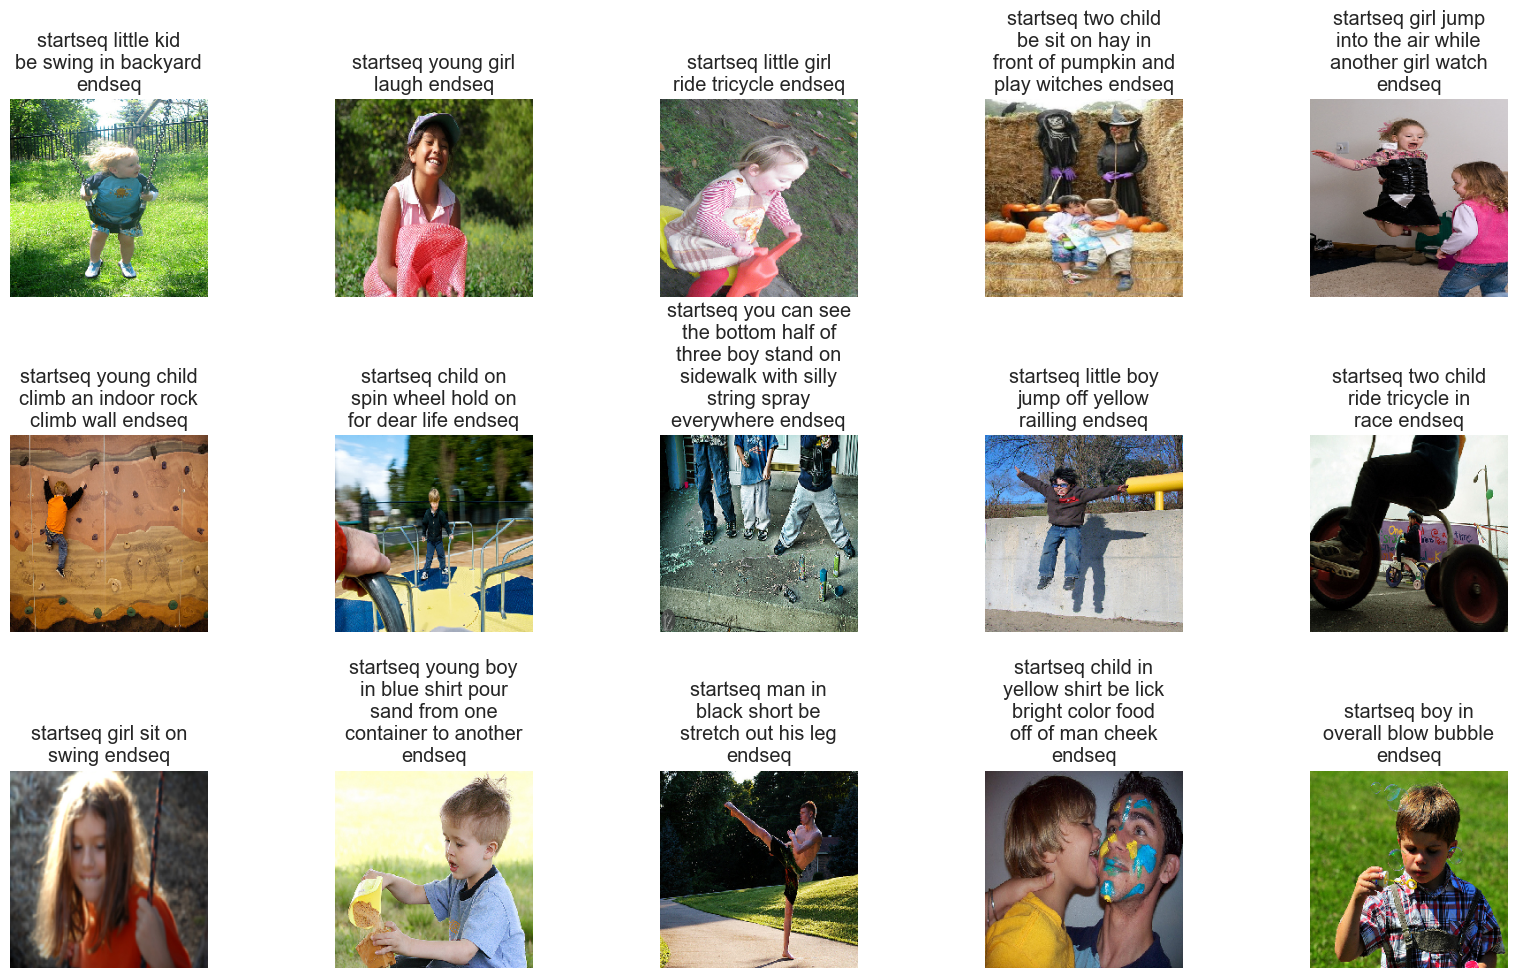

In [20]:
display_images(samples)